In [34]:
import sys
sys.executable
!{sys.executable} -m pip install xgboost

You should consider upgrading via the '/run/media/imsanskar/My_files/Projects/DS/.env/bin/python3.9 -m pip install --upgrade pip' command.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [3]:
df = pd.read_csv("./data/AviationData.csv", encoding='cp1252', low_memory = False)
# Drop columns with little information
# df.drop(['Latitude', 'Longitude','Air.carrier', 'Airport.Name', 'Airport.Code', 'Schedule', 'FAR.Description'], axis='columns', inplace = True)
df.shape

(88889, 31)

## Preprocessing

In [4]:
planedata_01 = df[['Location','Latitude','Longitude','Injury.Severity',
                         'Aircraft.damage', 'Aircraft.Category', 'Make', 
                         'Number.of.Engines', 'Engine.Type', 
                         'Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                         'Weather.Condition','Broad.phase.of.flight',
                         'Total.Uninjured','Total.Minor.Injuries']]

planedata_01 =pd.DataFrame(planedata_01)
# In order not to remove those with NaN that could drastically reduce our dataset
# We put in a place holder of 'UNKNOWN' instead

planedata_01['Location'].fillna('UNKNOWN',inplace = True)
planedata_01['Latitude'].fillna('UNKNOWN',inplace = True)
planedata_01['Longitude'].fillna('UNKNOWN',inplace = True)
planedata_01['Injury.Severity'].fillna('UNKNOWN',inplace = True)

planedata_01['Aircraft.damage'].fillna('UNKNOWN',inplace=True)
planedata_01['Aircraft.damage'].replace({'Unknown':'UNKNOWN'},inplace=True)
planedata_01 =planedata_01[planedata_01['Aircraft.damage'].str.contains("UNKNOWN")==False]

planedata_01['Aircraft.Category'].fillna('UNKNOWN',inplace=True)
planedata_01['Aircraft.Category'].replace({'UNKNOWN':'Airplane'},inplace=True)
planedata_01 =planedata_01[planedata_01['Aircraft.Category'].str.contains("Airplane")==True]

planedata_01['Make'].fillna('UNKNOWN',inplace=True)
planedata_01['Number.of.Engines'].fillna('UNKNOWN',inplace=True)
#planedata_01 =planedata_01[planedata_01['Number.of.Engines'].str.contains("UNKNOWN")==False]
#planedata_01['Engine.Type'].fillna('UNKNOWN',inplace=True)
planedata_01 =planedata_01[planedata_01['Engine.Type'].str.contains("Unknown")==False]
#planedata_01 =planedata_01[planedata_01['Engine.Type'].str.contains("UNKNOWN")==False]
planedata_01['Total.Fatal.Injuries'].fillna(0,inplace=True)
planedata_01['Total.Minor.Injuries'].fillna(0,inplace=True)
planedata_01['Total.Uninjured'].fillna(0,inplace=True)
planedata_01['Total.Serious.Injuries'].fillna(0,inplace=True)
planedata_01['Broad.phase.of.flight'].fillna('UNKNOWN',inplace = True)
planedata_01 =planedata_01[planedata_01['Broad.phase.of.flight'].str.contains("Unknown")==False]
planedata_01 =planedata_01[planedata_01['Broad.phase.of.flight'].str.contains("UNKNOWN")==False]
planedata_01['Weather.Condition'].fillna('UNKNOWN',inplace = True)
planedata_01['Weather.Condition'].replace({'Unk':'UNKNOWN'},inplace=True)
planedata_01['Weather.Condition'].replace({'UNK':'UNKNOWN'},inplace=True)
planedata_01 =planedata_01[planedata_01['Weather.Condition'].str.contains("UNKNOWN")==False]
#planedata_01['Engine.Type'].fillna('UNKNOWN',inplace=True)


df = planedata_01
df.head()

,Location,Latitude,Longitude,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Number.of.Engines,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Weather.Condition,Broad.phase.of.flight,Total.Uninjured,Total.Minor.Injuries
2,"Saltville, VA",36.922223,-81.878056,Fatal(3),Destroyed,Airplane,Cessna,1.0,Reciprocating,3.0,0.0,IMC,Cruise,0.0,0.0
3,"EUREKA, CA",UNKNOWN,UNKNOWN,Fatal(2),Destroyed,Airplane,Rockwell,1.0,Reciprocating,2.0,0.0,IMC,Cruise,0.0,0.0
5,"BOSTON, MA",42.445277,-70.758333,Non-Fatal,Substantial,Airplane,Mcdonnell Douglas,2.0,Turbo Fan,0.0,0.0,VMC,Climb,44.0,1.0
7,"PULLMAN, WA",UNKNOWN,UNKNOWN,Non-Fatal,Substantial,Airplane,Cessna,1.0,Reciprocating,0.0,0.0,VMC,Takeoff,2.0,0.0
8,"EAST HANOVER, NJ",UNKNOWN,UNKNOWN,Non-Fatal,Substantial,Airplane,Cessna,2.0,Reciprocating,0.0,0.0,IMC,Landing,2.0,0.0


## Dimensionality Reduction 

In [6]:
dataframe_damage_info = df[df['Aircraft.damage'] != 'Unknown' ] 
key_value = {
    'Minor': 0,
    'Substantial': 1,
    'Destroyed': 2,
}

dataframe_damage_info['Aircraft.damage'] = dataframe_damage_info['Aircraft.damage'].map(key_value)

dataframe_damage_info = dataframe_damage_info.dropna()
X_dataset = dataframe_damage_info[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']]
Y_dataset = dataframe_damage_info['Aircraft.damage']

Y_dataset

2        2
3        2
5        1
7        1
8        1
        ..
63904    1
63905    1
63909    1
63910    1
63911    1
Name: Aircraft.damage, Length: 57114, dtype: int64

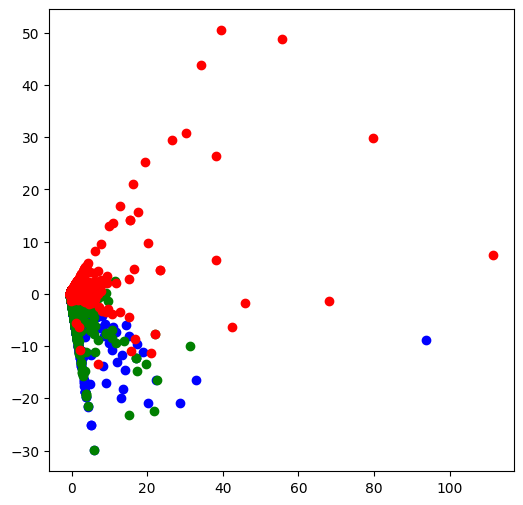

In [37]:
X_train, X_test, y_train, y_test  = train_test_split(X_dataset, Y_dataset, test_size = 0.2)
model_xgboost = xgb.XGBClassifier(learning_rate=0.01,          #weightage of every tree
                                      max_depth=10,            #maximum tree depth in model
                                      n_estimators=1000,      #model will create max of 5000 trees
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_test, y_test)]
model_xgboost.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-auc:0.87283
[1]	validation_0-auc:0.87283
[2]	validation_0-auc:0.87282
[3]	validation_0-auc:0.87281
[4]	validation_0-auc:0.87277
[5]	validation_0-auc:0.87277
[6]	validation_0-auc:0.87269
[7]	validation_0-auc:0.87268
[8]	validation_0-auc:0.87267
[9]	validation_0-auc:0.87263
[10]	validation_0-auc:0.87258
[11]	validation_0-auc:0.87255
[12]	validation_0-auc:0.87252
[13]	validation_0-auc:0.87251
[14]	validation_0-auc:0.87250
[15]	validation_0-auc:0.87249
[16]	validation_0-auc:0.87248
[17]	validation_0-auc:0.87246
[18]	validation_0-auc:0.87248
[19]	validation_0-auc:0.87247
[20]	validation_0-auc:0.87247
[21]	validation_0-auc:0.87242
[22]	validation_0-auc:0.87242
[23]	validation_0-auc:0.87190
[24]	validation_0-auc:0.87190
[25]	validation_0-auc:0.87189
[26]	validation_0-auc:0.87189
[27]	validation_0-auc:0.87192
[28]	validation_0-auc:0.87193
[29]	validation_0-auc:0.87192
[30]	validation_0-auc:0.87179
[31]	validation_0-auc:0.87180
[32]	validation_0-auc:0.87178
[33]	validation_0-au

[268]	validation_0-auc:0.87048
[269]	validation_0-auc:0.87048
[270]	validation_0-auc:0.87048
[271]	validation_0-auc:0.87062
[272]	validation_0-auc:0.87062
[273]	validation_0-auc:0.87061
[274]	validation_0-auc:0.87061
[275]	validation_0-auc:0.87062
[276]	validation_0-auc:0.87063
[277]	validation_0-auc:0.87096
[278]	validation_0-auc:0.87096
[279]	validation_0-auc:0.87114
[280]	validation_0-auc:0.87146
[281]	validation_0-auc:0.87146
[282]	validation_0-auc:0.87145
[283]	validation_0-auc:0.87146
[284]	validation_0-auc:0.87146
[285]	validation_0-auc:0.87146
[286]	validation_0-auc:0.87146
[287]	validation_0-auc:0.87146
[288]	validation_0-auc:0.87146
[289]	validation_0-auc:0.87147
[290]	validation_0-auc:0.87146
[291]	validation_0-auc:0.87144
[292]	validation_0-auc:0.87145
[293]	validation_0-auc:0.87144
[294]	validation_0-auc:0.87145
[295]	validation_0-auc:0.87150
[296]	validation_0-auc:0.87152
[297]	validation_0-auc:0.87152
[298]	validation_0-auc:0.87152
[299]	validation_0-auc:0.87152
[300]	va

[533]	validation_0-auc:0.87229
[534]	validation_0-auc:0.87229
[535]	validation_0-auc:0.87229
[536]	validation_0-auc:0.87229
[537]	validation_0-auc:0.87229
[538]	validation_0-auc:0.87231
[539]	validation_0-auc:0.87232
[540]	validation_0-auc:0.87233
[541]	validation_0-auc:0.87233
[542]	validation_0-auc:0.87233
[543]	validation_0-auc:0.87233
[544]	validation_0-auc:0.87233
[545]	validation_0-auc:0.87234
[546]	validation_0-auc:0.87234
[547]	validation_0-auc:0.87235
[548]	validation_0-auc:0.87240
[549]	validation_0-auc:0.87240
[550]	validation_0-auc:0.87239
[551]	validation_0-auc:0.87238
[552]	validation_0-auc:0.87239
[553]	validation_0-auc:0.87239
[554]	validation_0-auc:0.87240
[555]	validation_0-auc:0.87240
[556]	validation_0-auc:0.87240
[557]	validation_0-auc:0.87241
[558]	validation_0-auc:0.87241
[559]	validation_0-auc:0.87241
[560]	validation_0-auc:0.87241
[561]	validation_0-auc:0.87241
[562]	validation_0-auc:0.87242
[563]	validation_0-auc:0.87242
[564]	validation_0-auc:0.87242
[565]	va

[798]	validation_0-auc:0.87243
[799]	validation_0-auc:0.87243
[800]	validation_0-auc:0.87243
[801]	validation_0-auc:0.87242
[802]	validation_0-auc:0.87242
[803]	validation_0-auc:0.87241
[804]	validation_0-auc:0.87241
[805]	validation_0-auc:0.87241
[806]	validation_0-auc:0.87241
[807]	validation_0-auc:0.87241
[808]	validation_0-auc:0.87241
[809]	validation_0-auc:0.87241
[810]	validation_0-auc:0.87240
[811]	validation_0-auc:0.87240
[812]	validation_0-auc:0.87240
[813]	validation_0-auc:0.87240
[814]	validation_0-auc:0.87240
[815]	validation_0-auc:0.87240
[816]	validation_0-auc:0.87240
[817]	validation_0-auc:0.87241
[818]	validation_0-auc:0.87241
[819]	validation_0-auc:0.87241
[820]	validation_0-auc:0.87241
[821]	validation_0-auc:0.87241
[822]	validation_0-auc:0.87241
[823]	validation_0-auc:0.87241
[824]	validation_0-auc:0.87241
[825]	validation_0-auc:0.87241
[826]	validation_0-auc:0.87241
[827]	validation_0-auc:0.87239
[828]	validation_0-auc:0.87239
[829]	validation_0-auc:0.87239
[830]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Micro F1 score: 86.07196008053927
Macro F1 score: 68.19319319416658


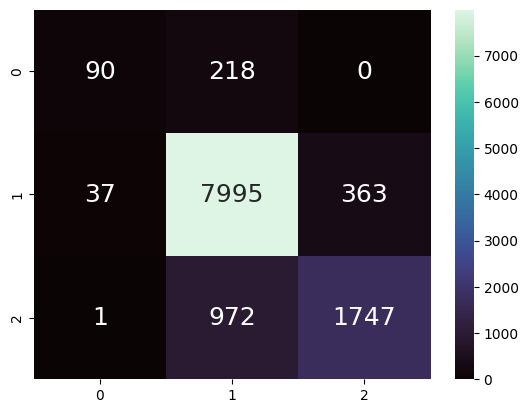

In [38]:
y_test_pred = model_xgboost.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},cmap="mako")
print(f"Micro F1 score: {f1_score(y_test, y_test_pred, average='micro') * 100}")
print(f"Macro F1 score: {f1_score(y_test, y_test_pred, average='macro') * 100}")
plt.show()

## PCA and XGBoost 

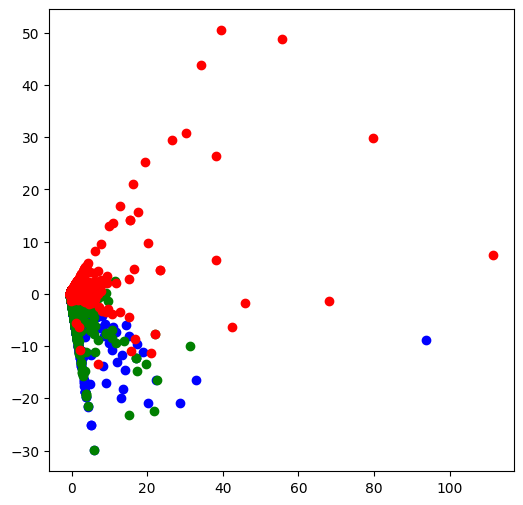

In [27]:
pca = PCA(n_components = 2)
pca.fit(X_dataset)
scaled_X_data = StandardScaler().fit_transform(X_dataset)
X_pca = pca.fit_transform(scaled_X_data)

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.scatter(X_pca[Y_dataset==0, 0], X_pca[Y_dataset==0, 1], color='blue',label='0')
ax.scatter(X_pca[Y_dataset==1, 0], X_pca[Y_dataset==1, 1], color='green',label='1')
ax.scatter(X_pca[Y_dataset==2, 0], X_pca[Y_dataset==2, 1], color='red',label='2')

plt.show()

In [39]:
X_train, X_test, y_train, y_test  = train_test_split(X_pca, Y_dataset, test_size = 0.2)
model_xgboost = xgb.XGBClassifier(learning_rate=0.001,          #weightage of every tree
                                      max_depth=10,            #maximum tree depth in model
                                      n_estimators=1000,      #model will create max of 5000 trees
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_test, y_test)]
model_xgboost.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-auc:0.86118
[1]	validation_0-auc:0.86121
[2]	validation_0-auc:0.86118
[3]	validation_0-auc:0.86121
[4]	validation_0-auc:0.86118
[5]	validation_0-auc:0.86119
[6]	validation_0-auc:0.86119
[7]	validation_0-auc:0.86118
[8]	validation_0-auc:0.86117
[9]	validation_0-auc:0.86117
[10]	validation_0-auc:0.86117
[11]	validation_0-auc:0.86117
[12]	validation_0-auc:0.86117
[13]	validation_0-auc:0.86120
[14]	validation_0-auc:0.86120
[15]	validation_0-auc:0.86120
[16]	validation_0-auc:0.86120
[17]	validation_0-auc:0.86120
[18]	validation_0-auc:0.86120
[19]	validation_0-auc:0.86121
[20]	validation_0-auc:0.86121
[21]	validation_0-auc:0.86119
[22]	validation_0-auc:0.86119
[23]	validation_0-auc:0.86115
[24]	validation_0-auc:0.86115
[25]	validation_0-auc:0.86115
[26]	validation_0-auc:0.86115
[27]	validation_0-auc:0.86115
[28]	validation_0-auc:0.86115
[29]	validation_0-auc:0.86114
[30]	validation_0-auc:0.86114
[31]	validation_0-auc:0.86114
[32]	validation_0-auc:0.86114
[33]	validation_0-au

[268]	validation_0-auc:0.86070
[269]	validation_0-auc:0.86070
[270]	validation_0-auc:0.86070
[271]	validation_0-auc:0.86069
[272]	validation_0-auc:0.86069
[273]	validation_0-auc:0.86068
[274]	validation_0-auc:0.86068
[275]	validation_0-auc:0.86068
[276]	validation_0-auc:0.86068
[277]	validation_0-auc:0.86068
[278]	validation_0-auc:0.86068
[279]	validation_0-auc:0.86068
[280]	validation_0-auc:0.86068
[281]	validation_0-auc:0.86068
[282]	validation_0-auc:0.86068
[283]	validation_0-auc:0.86068
[284]	validation_0-auc:0.86068
[285]	validation_0-auc:0.86068
[286]	validation_0-auc:0.86068
[287]	validation_0-auc:0.86068
[288]	validation_0-auc:0.86068
[289]	validation_0-auc:0.86068
[290]	validation_0-auc:0.86068
[291]	validation_0-auc:0.86068
[292]	validation_0-auc:0.86068
[293]	validation_0-auc:0.86068
[294]	validation_0-auc:0.86067
[295]	validation_0-auc:0.86064
[296]	validation_0-auc:0.86064
[297]	validation_0-auc:0.86064
[298]	validation_0-auc:0.86064
[299]	validation_0-auc:0.86063
[300]	va

[533]	validation_0-auc:0.86043
[534]	validation_0-auc:0.86043
[535]	validation_0-auc:0.86043
[536]	validation_0-auc:0.86043
[537]	validation_0-auc:0.86043
[538]	validation_0-auc:0.86044
[539]	validation_0-auc:0.86044
[540]	validation_0-auc:0.86044
[541]	validation_0-auc:0.86044
[542]	validation_0-auc:0.86044
[543]	validation_0-auc:0.86043
[544]	validation_0-auc:0.86043
[545]	validation_0-auc:0.86043
[546]	validation_0-auc:0.86043
[547]	validation_0-auc:0.86043
[548]	validation_0-auc:0.86043
[549]	validation_0-auc:0.86043
[550]	validation_0-auc:0.86043
[551]	validation_0-auc:0.86043
[552]	validation_0-auc:0.86043
[553]	validation_0-auc:0.86043
[554]	validation_0-auc:0.86043
[555]	validation_0-auc:0.86043
[556]	validation_0-auc:0.86043
[557]	validation_0-auc:0.86043
[558]	validation_0-auc:0.86043
[559]	validation_0-auc:0.86042
[560]	validation_0-auc:0.86042
[561]	validation_0-auc:0.86042
[562]	validation_0-auc:0.86042
[563]	validation_0-auc:0.86041
[564]	validation_0-auc:0.86041
[565]	va

[798]	validation_0-auc:0.86022
[799]	validation_0-auc:0.86022
[800]	validation_0-auc:0.86022
[801]	validation_0-auc:0.86022
[802]	validation_0-auc:0.86022
[803]	validation_0-auc:0.86022
[804]	validation_0-auc:0.86022
[805]	validation_0-auc:0.86022
[806]	validation_0-auc:0.86022
[807]	validation_0-auc:0.86022
[808]	validation_0-auc:0.86022
[809]	validation_0-auc:0.86021
[810]	validation_0-auc:0.86021
[811]	validation_0-auc:0.86021
[812]	validation_0-auc:0.86021
[813]	validation_0-auc:0.86021
[814]	validation_0-auc:0.86021
[815]	validation_0-auc:0.86022
[816]	validation_0-auc:0.86022
[817]	validation_0-auc:0.86021
[818]	validation_0-auc:0.86021
[819]	validation_0-auc:0.86020
[820]	validation_0-auc:0.86020
[821]	validation_0-auc:0.86021
[822]	validation_0-auc:0.86020
[823]	validation_0-auc:0.86021
[824]	validation_0-auc:0.86000
[825]	validation_0-auc:0.86000
[826]	validation_0-auc:0.86001
[827]	validation_0-auc:0.86001
[828]	validation_0-auc:0.86001
[829]	validation_0-auc:0.86001
[830]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Micro F1 score: 85.14400770375558
Macro F1 score: 66.41646597419029


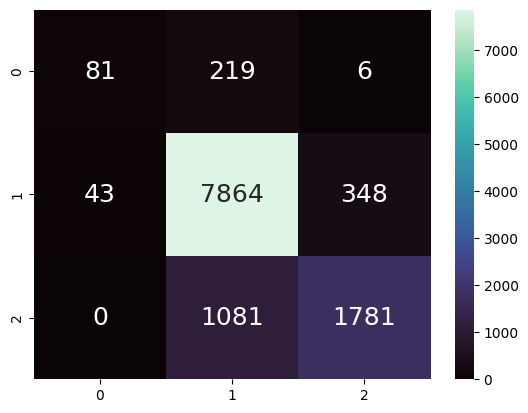

In [41]:
y_test_pred = model_xgboost.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},cmap="mako")
print(f"Micro F1 score: {f1_score(y_test, y_test_pred, average='micro') * 100}")
print(f"Macro F1 score: {f1_score(y_test, y_test_pred, average='macro') * 100}")
plt.show()

## Conclusion
Results when trained with natural data was better than when it was trained with data obtained from *PCA*. It may be because there can be loss of information when applying PCA. However, the difference is not significant so we cannot make concrete conlusion. 